# 12. Revisiting the single-spore experiments

## Numerical experiments - Week 15/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Having refined the models and obtained more insight into the diffusive properties of molecules in _Aspergillus_ conidia, the inhibitor release from a single spore is simulated under several assumed diffusion and permeation constants and multiple estimated permeation constants for targeted 4-hour depletion percentages.

## Prerequisite libraries

In [1]:
using PyPlot
using CurveFit
using Statistics
using MeshGrid
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis

## 1. Estimating the constants

### 1.1. Diffusion constants

#### 1.1.1. Known values

Several diffusivities of analogue systems are known:

- the diffusion constant of glucose in water is $D=6\times10^{-6}\ \textrm{cm}^2/\textrm{s}=600\ \mu\textrm{m}^2/\textrm{s}$ [1];
- the diffusion constant of glucose in an agarose film is $D=6.38\times10^{-6}\ \textrm{cm}^2/\textrm{s}=638\ \mu\textrm{m}^2/\textrm{s}$ [2];
- the diffusion constant of glucose in cellulose nanofibrils is $D=1.7\times10^{-7}\ \textrm{cm}^2/\textrm{s}=17\ \mu\textrm{m}^2/\textrm{s}$ [3].

#### 1.1.2. Diffusion constants of 1-Octen-3-ol

The diffusion constant of 1-Octen-3-ol in water can be obtained from the Stokes-Einstein relation

$$
D=\frac{k_BT}{6\pi\eta a},
$$

considering a temperature of $T=303.15\ \textrm{K}$ (a common cultivation temperature for _Aspergillus_ conidia) and thus a thermodynamic constant of $k_BT=4.18\times10^{-21}\ \textrm{J}$.

The Stokes radius of 1-octen-3-ol can be computed from its volume, which is obtained by multiplying its molecular mass $m_M$ by its average density $\rho$. Since

$$
m_M(\textrm{1-octen-3-ol})=128.21\ \textrm{g/mol},
$$

$$
\rho(\textrm{1-octen-3-ol})=0.837\ \textrm{g/mL},
$$

the molecular volume is

$$
V_M(\textrm{1-octen-3-ol})=\frac{128.21\ \textrm{g/mol}}{0.837\ \textrm{g/mL}\cdot 6.022\times10^{23}\ \textrm{mol}^{-1}}\approx 2.54364\times 10^{-24}\ \textrm{mL},
$$

which yields a Stokes radius of

$$
a(\textrm{1-octen-3-ol}) = \left(\frac{3}{4\pi}V_M\right)^{1/3}=0.393\ \textrm{nm}.
$$

Using the viscosity of water at $303.15 \textrm{K}$,

$$
\eta(\textrm{water})=0.797 \ \textrm{mPa s},
$$

one arrives at

$$
D(\textrm{1-octen-3-ol in water})\approx 6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=690.16\ \mu\textrm{m}^2/\textrm{s}.
$$



In [3]:
# Calculation of diffusion constant
a = compute_stokes_radius(128.21, 0.822)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.590057057617608e-10
Stokes radius: 0.00039543360500816373


690.161673634019

Since the Stokes radius of glucose is approximately $0.36\ \textrm{nm}$, one can obtain a comparable diffusion constant for glucose using the ratio of the Stokes radii:

$$
D^*(\textrm{glucose in water})=\frac{a(\textrm{1-octen-3-ol})}{a(\textrm{glucose})}\times D(\textrm{1-octen-3-ol in water})\approx 7.534\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=753.4\ \mu\textrm{m}^2/\textrm{s}.
$$

This value is slightly higher than the constant found in literature, possibly due to the sensitivity of the water viscosity $\eta$ to temperature. Similar to glucose, the diffusivity of 1-octen-3-ol in an agarose film would be comparable to its diffusivity in water. One can use the ratio of the diffusivities in water to obtain

$$
D(\textrm{1-octen-3-ol in agarose})\approx \frac{D(\textrm{glucose in agarose})}{D(\textrm{glucose in water})}\times D(\textrm{1-octen-3-ol in water})= 7.3387\times 10^{-6}\ \textrm{cm}^2/\textrm{s}=733.87\ \mu\textrm{m}^2/\textrm{s}.
$$

In cellulose, the diffusion coefficient would be

$$
D(\textrm{1-octen-3-ol in cellulose})\approx \frac{D(\textrm{glucose in cellulose})}{D(\textrm{glucose in water})}\times D(\textrm{1-octen-3-ol in water})= 1.9555\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=19.555\ \mu\textrm{m}^2/\textrm{s}.
$$

#### 1.1.4. Diffusion constants of other VOCs

3-octanone is a structural isomer of 1-octen-3-ol and has the same molecular weight and an almost identical density of $0.822\ \textrm{g/mL}$. 3-octanol has a molecular weight of $130.23\ \textrm{g/mol}$ and a density of $0.818\ \textrm{g/mL}$, yielding a Stokes radius of approximately the same size as 1-octen-3-ol and a negligibly different diffusion constant. Hence, the diffusivity of the three VOCs can be considered equivalent.

In [4]:
# Calculation of diffusion constant
a = compute_stokes_radius(130.23, 0.818)
println("Stokes radius: ", a)
compute_D_from_radius_and_viscosity(a, 0.797)

Molecular volume: 2.643729308752991e-10
Stokes radius: 0.000398146398994561


685.4592163404097

#### 1.1.4. Diffusion constants of a heat-labile peptide

Assuming a protein with a Stokes radius of $6.0\ \textrm{nm}$, which is the upper limit of the experimentally observed molecular passages through the conidial cell wall [4], a diffusion constant through water,

$$
D(\textrm{heat-labile peptide in water})\approx 4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=45.4855\ \mu\textrm{m}^2/\textrm{s},
$$

can be approximated using the Stokes-Einstein relation. Relating the water-diffusivity to that of glucose, the diffusivity of the protein through agarose and cellulose could be roughly estimated:

$$
D(\textrm{heat-labile peptide in agarose})\approx \frac{D(\textrm{glucose in agarose})}{D(\textrm{glucose in water})}\times D(\textrm{heat-labile peptide in water})= 4.8366\times 10^{-7}\ \textrm{cm}^2/\textrm{s}=48.366\ \mu\textrm{m}^2/\textrm{s}.
$$

$$
D(\textrm{heat-labile peptide in cellulose})\approx \frac{D(\textrm{glucose in cellulose})}{D(\textrm{glucose in water})}\times D(\textrm{heat-labile peptide in water})= 1.29\times 10^{-8}\ \textrm{cm}^2/\textrm{s}=1.29\ \mu\textrm{m}^2/\textrm{s}.
$$

In [5]:
# Calculation of diffusion constant
a = 6.0 # nm
um2_to_cm2(compute_D_from_radius_and_viscosity(nm_to_um(a), 0.797))

4.5485519773927985e-7

### 1.2. Permeation constants

#### 1.2.1. Known values

The permeation constant of glucose in synthetic lipid bylayer found in literature is $P_s=1.4\times10^{-10}\ \textrm{cm/s}$ [5] or $P_s=2.4\times10^{-10}\ \textrm{cm/s}$ [6]. A rough average of $P_s=2.0\times10^{-10}\ \textrm{cm/s}$ is taken.

Using the Meyer-Overton rule,

$$
P_s=\frac{KD}{d},
$$

a lipid bilayer thickness $d=3.8\ \textrm{nm}$ in its liquid phase [7] and the octanol-water partition coefficient of glucose, $K=6.31\times 10^{-4}$ ($\log{K}=-3.2$) [8], the diffusion of glucose through the lipid bilayer can be quantified as

$$
D(\textrm{glucose in lipid bilayer})=\frac{P_sd}{K}=\frac{2.4\times10^{-10}\ \textrm{cm/s}\cdot 3.8\times 10^{-7}\ \textrm{cm}}{6.31\times 10^{-4}}\approx 1.186\times 10^{-13}\ \textrm{cm}^2/\textrm{s}=1.186\times 10^{-5}\ \mu\textrm{m}^2/\textrm{s}.
$$

In [22]:
# Calculation of diffusion constant
D = convert_Ps_to_D(cm_to_um(2e-10), 6.41e-4, nm_to_um(3.8))

1.185647425897036e-5

#### 1.2.2. Permeation constants of 1-octen-3-ol

1-octen-3-ol is less polar than glucose and its octanol-water partition coefficient is $K=316.23$ ($\log{K}=2.5$). If its diffusivity in lipid bilayers is related to the $D$ coefficient of glucose via the Stokes radii, then the Meyer-Overton rule can be used to obtain its permeation coefficient

$$
P_s(\textrm{1-octen-3-ol through lipid bilayer})=\frac{K(\textrm{1-octen-3-ol})\cdot D(\textrm{glucose in lipid bilayer})}{d_{\textrm{lb}}}\cdot\frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\approx 9.04\times10^{-5}\ \textrm{cm/s}=0.904\ \mu\textrm{m/s}.
$$

This would describe a scenario in which the cell membrane is the rate-limiting layer of the spore envelope.

In [23]:
# Calculation of permeation constant
convert_D_to_Ps(D, 316.23, nm_to_um(3.8)) * 0.36 / 0.393

0.903826320991771

Relating the Stokes radii, the diffusivity of 1-octen-3-ol in a lipid membrane is

$$
D(\textrm{1-octen-3-ol in lipid bilayer})=D(\textrm{glucose in lipid bilayer})\cdot\frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\approx 1.086\times10^{-13}\ \textrm{cm}^2/\textrm{s}=1.086\times 10^{-5}\ \mu\textrm{m}^2/\textrm{s}.
$$

In [24]:
D * 0.36 / 0.393

1.0860892450965216e-5

The octanol-water partitioning can be used in a more general category of membrane permeabilities [15], to which hydrophobin rodlet layers arguably belong. Considering a thickness of the rodlet-melanin layer of about $10\ \textrm{nm}$ thickness, this yields a permeation coefficient of

$$
P_s(\textrm{1-octen-3-ol through hydrophobin})=\frac{K(\textrm{1-octen-3-ol})\cdot D(\textrm{glucose in lipid bilayer})}{d_{\textrm{rod}}}\cdot\frac{a(\textrm{glucose})}{a(\textrm{1-octen-3-ol})}\approx 3.43\times10^{-5}\ \textrm{cm/s}=0.343\ \mu\textrm{m/s}.
$$

In [25]:
# Calculation of permeation constant
convert_D_to_Ps(D, 316.23, nm_to_um(10)) * 0.36 / 0.393

0.343454001976873

This permeability could be further modulated by the porosity of the hydrophobin layer, but evidence suggests that the rodlet structure is densely packed, so the effect of pores would be minimal.

The Meyer-Overton rule generally does not apply in the same form to barriers different from lipid bilayers. In porous barriers, filled with water, that weakly interact with the solute, the partition coefficient can be approximated to $K\approx 1$, indicating a lack of preference for the molecule to reside inside or outside the barrier. Other factors like the porosity of the barrier can be assimilated in an effective permeation constant

$$
P_{\textrm{eff}}\approx\frac{D}{d}.
$$

It is hereby assumed that there is a rate-limiting permeability of the cell wall components, equivalent to the permeability of a specific substance, which determines the release of the inhibitor from the spore. Subtracting the $10\ \textrm{nm}$ rodlet thickness from the upper limit ($400\ \textrm{nm}$) and lower limit ($200\ \textrm{nm}$) of the cell wall thickness in _Aspergillus_ conidia [9], one can transform the estimated diffusion constants of 1-octen-3-ol into permeation constants:

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through 390 nm agarose})=\frac{D(\textrm{1-octen-3-ol in agarose})}{d}=\frac{733.87\ \mu\textrm{m}^2/\textrm{s}}{0.39\ \mu\textrm{m}}=0.1881718\ \textrm{cm/s}=1881.718\ \mu\textrm{m/s},
$$

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through 190 nm agarose})=\frac{D(\textrm{1-octen-3-ol in agarose})}{d}=\frac{733.87\ \mu\textrm{m}^2/\textrm{s}}{0.19\ \mu\textrm{m}}=0.3632421\ \textrm{cm/s}=3632.421\ \mu\textrm{m/s},
$$

In [ ]:
# Calculation of permeation constant
convert_D_to_Ps(733.87, 1, 0.39)

1881.7179487179487

In [26]:
# Calculation of permeation constant (approximated as water)
convert_D_to_Ps(690.16, 1, 0.39)

1769.6410256410254

In [2]:
# Calculation of permeation constant (approximated as water, 200 nm cell wall)
convert_D_to_Ps(690.16, 1, 0.19)

3632.4210526315787

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through 390 nm cellulose})=\frac{D(\textrm{1-octen-3-ol in cellulose})}{d}=\frac{19.555\ \mu\textrm{m}^2/\textrm{s}}{0.39\ \mu\textrm{m}}=0.0050141\ \textrm{cm/s}=50.141\ \mu\textrm{m/s}.
$$

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through 190 nm cellulose})=\frac{D(\textrm{1-octen-3-ol in cellulose})}{d}=\frac{19.555\ \mu\textrm{m}^2/\textrm{s}}{0.19\ \mu\textrm{m}}=0.0102921\ \textrm{cm/s}=102.921\ \mu\textrm{m/s}.
$$

In [6]:
# Calculation of permeation constant
convert_D_to_Ps(19.555, 1, 0.39)

50.141025641025635

In [3]:
# Calculation of permeation constant (2000 nm cell wall)
convert_D_to_Ps(19.555, 1, 0.19)

102.92105263157895

As a control value, one can also consider the case when the entire cell wall does not impose any obstruction compared to the medium, yielding an effective permeability of a water-like substance:

$$
P_{\textrm{eff}}(\textrm{1-octen-3-ol through 400 nm water})=\frac{D(\textrm{1-octen-3-ol in water})}{d}=\frac{19.555\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.17254\ \textrm{cm/s}=1725.4\ \mu\textrm{m/s}.
$$

In [9]:
# Calculation of permeation constant
convert_D_to_Ps(690.16, 1, 0.4)

1725.3999999999999

#### 1.2.3. Permeation constants of a heat-labile peptide

It is generally difficult to narrow down the range of partition coefficients for potential inhibitor proteins due to their size and complexity. Furthermore, in natural scenarios, proteins usually permeate cell membranes with the help of channels or transporters. Furthermore, the hydrophobin layer is known to only permit molecules lighter than $200\ \textrm{Da}$ [12] (corresponding to a Stokes radius of approximately $0.39\ \textrm{nm}$) via normal diffusion. Therefore, the scenario of a protein permeating the outer cell wall or the membrane is not considered.

Regarding barriers of polysaccharides, the previously used approach can be applied to link the estimated diffusion constants to permeation constants:

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through 390 nm agarose})=\frac{D(\textrm{heat-labile peptide in agarose})}{d}=\frac{48.366}{0.39\ \mu\textrm{m}}=0.0116629\ \textrm{cm/s}=116.629\ \mu\textrm{m/s},
$$

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through 190 nm agarose})=\frac{D(\textrm{heat-labile peptide in agarose})}{d}=\frac{48.366}{0.19\ \mu\textrm{m}}=0.0239397\ \textrm{cm/s}=239.397\ \mu\textrm{m/s},
$$

In [11]:
# Calculation of permeation constant
convert_D_to_Ps(48.366, 1, 0.39)

124.0153846153846

In [27]:
# Calculation of permeation constant (water-like)
convert_D_to_Ps(45.4855, 1, 0.39)

116.62948717948719

In [5]:
# Calculation of permeation constant (water-like, 200 nm cell wall)
convert_D_to_Ps(45.4855, 1, 0.19)

239.39736842105265

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through 390 nm cellulose})=\frac{D(\textrm{heat-labile peptide in cellulose})}{d}=\frac{1.29\ \mu\textrm{m}^2/\textrm{s}}{0.39\ \mu\textrm{m}}=3.3\times 10^{-4}\ \textrm{cm/s}=3.3\ \mu\textrm{m/s}.
$$

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through 190 nm cellulose})=\frac{D(\textrm{heat-labile peptide in cellulose})}{d}=\frac{1.29\ \mu\textrm{m}^2/\textrm{s}}{0.19\ \mu\textrm{m}}=6.789\times 10^{-4}\ \textrm{cm/s}=6.789\ \mu\textrm{m/s}.
$$

In [12]:
# Calculation of permeation constant
convert_D_to_Ps(1.29, 1, 0.39)

3.3076923076923075

In [6]:
# Calculation of permeation constant
convert_D_to_Ps(1.29, 1, 0.19)

6.7894736842105265

The control permeability through a fully water-like barrier is

$$
P_{\textrm{eff}}(\textrm{heat-labile peptide through 400 nm water})=\frac{D(\textrm{heat-labile peptide in water})}{d}=\frac{45.4855\ \mu\textrm{m}^2/\textrm{s}}{0.4\ \mu\textrm{m}}=0.01137\ \textrm{cm/s}=113.7\ \mu\textrm{m/s}.
$$

In [13]:
# Calculation of permeation constant
convert_D_to_Ps(45.4855, 1, 0.4)

113.71375

### 1.3. Combining permeabilities

When combining layers with different permeabilities, the net permeation constant $P_{\textrm{eff}}$ can be computed through the formula

$$
\begin{equation}
\frac{1}{P_{\textrm{eff}}}=\frac{1}{P_1}+\frac{1}{P_2}+\ldots +\frac{1}{P_n},
\end{equation}
$$

where $P_i, \ i=1,2,\ldots n$ are the permeabilities of the separate layers.

Some possible permeation-defining configurations are:

1. an inhibitor source and receiver expressed in the outermost layer of the cell wall, virtually unobstructed by any layers, only limited by diffusion in water;
2. an inhibitor source and receiver embedded between the inner and outer cell wall layers, obstructed only by the hydrophobin-melanin layer;
3. an inhibitor source and receiver embedded deep in the inner cell wall layer, obstructed by polysaccharide network and the hydrophobin-melanin layer;
4. an inhibitor source and receiver inside the spore interior, obstructed by the cell membrane and the entire cell wall.

Disregarding the effect of unstirred water around the spore, these scenarios can be translated into permeabilities as follows:

1. $P_{\textrm{eff}}\approx\infty$,
2. $P_{\textrm{eff}}\approx P_{\textrm{hp}}$,
3. $P_{\textrm{eff}}=\left(\frac{1}{P_{\textrm{hp}}}+\frac{1}{P_{\textrm{agar}}}\right)^{-1}$ or $P_{\textrm{eff}}=\left(\frac{1}{P_{\textrm{hp}}}+\frac{1}{P_{\textrm{cel}}}\right)^{-1}$,
4. $P_{\textrm{eff}}=\left(\frac{1}{P_{\textrm{hp}}}+\frac{1}{P_{\textrm{agar}}}+\frac{1}{P_{\textrm{lb}}}\right)^{-1}$ or $P_{\textrm{eff}}=\left(\frac{1}{P_{\textrm{hp}}}+\frac{1}{P_{\textrm{cel}}}+\frac{1}{P_{\textrm{lb}}}\right)^{-1}$.

### 1.4. Table of diffusivities

The two candidate molecules for germination are a VOC like 1-octen-3-ol and a heat-labile peptide. The following tables summarise the diffusivities of different inhibitor candidates through different barrier types. As the diffusion in agarose is quite similar to that in water, the respective coefficients are set equal.

<!-- |                                    | 1-octen-3-ol | heat-labile peptide |
|------------------------------------|--------------|---------------------|
|water                               |$D=6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$D=4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|
|lipid bilayer membrane              |$P_s=2.0\times10^{-10}\ \textrm{cm/s}$|N/A|
|agarose-like cell wall (400 nm)     |$P_{\textrm{eff}}=0.1725\ \textrm{cm/s}$|$P_{\textrm{eff}}=0.011371375\ \textrm{cm/s}$|
|cellulose-like cell wall (400 nm)   |$P_{\textrm{eff}}=0.0039\ \textrm{cm/s}$|$P_{\textrm{eff}}=2.55\times 10^{-4}\ \textrm{cm/s}$| -->

For 1-octen-3-ol:

|1-octen-3-ol                       | $D$ | $P_{\textrm{eff}}$ |
|-----------------------------------|--------------|---------------------|
|water (400 nm)                     |$6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$0.17254\ \textrm{cm/s}$|
|agarose-like layer (190 nm)        |$6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$0.36324\ \textrm{cm/s}$|
|agarose-like layer (390 nm)        |$6.9016\times 10^{-6}\ \textrm{cm}^2/\textrm{s}$|$0.17696\ \textrm{cm/s}$|
|cellulose-like layer (190 nm)      |$1.9555\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|$0.0102921\ \textrm{cm/s}$|
|cellulose-like layer (390 nm)      |$1.9555\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|$0.0050141\ \textrm{cm/s}$|
|lipid bilayer membrane (3.8 nm)    |$1.086\times10^{-13}\ \textrm{cm}^2/\textrm{s}$|$9.04\times10^{-5}\ \textrm{cm/s}$|
|hydrophobin layer (10 nm)          |$1.086\times10^{-13}\ \textrm{cm}^2/\textrm{s}$|$3.43\times10^{-5}\ \textrm{cm/s}$|

For the heat-labile peptide:

|heat-labile peptide                | $D$ | $P_{\textrm{eff}}$ |
|-----------------------------------|--------------|---------------------|
|water (400 nm)                     |$4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|$0.01137\ \textrm{cm/s}$|
|agarose-like layer (190 nm)        |$4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|$0.0239397\ \textrm{cm/s}$|
|agarose-like layer (390 nm)        |$4.54855\times 10^{-7}\ \textrm{cm}^2/\textrm{s}$|$0.0116629\ \textrm{cm/s}$|
|cellulose-like layer (190 nm)      |$1.29\times 10^{-8}\ \textrm{cm}^2/\textrm{s}$|$6.789\times 10^{-4}\ \textrm{cm/s}$|
|cellulose-like layer (390 nm)      |$1.29\times 10^{-8}\ \textrm{cm}^2/\textrm{s}$|$3.3\times 10^{-4}\ \textrm{cm/s}$|
|lipid bilayer membrane (3.8 nm)    |N/A|N/A|
|hydrophobin layer (10 nm)          |N/A|N/A|

Considering the different scenarios for the barrier composition, the following composite permeabilities are computed:

In [7]:
# 1-octen-3-ol in rodlet + polysaccharides (agarose) - 200 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (agarose) - 200 nm cell wall: ", composite_Ps([0.36324, 3.43e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (agarose) - 400 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (agarose) - 400 nm cell wall: ", composite_Ps([0.17696, 3.43e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (cellulose) - 200 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (cellulose) - 200 num cell wall: ", composite_Ps([0.0102921, 3.43e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (cellulose) - 400 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (cellulose) - 400 num cell wall: ", composite_Ps([0.0050141, 3.43e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 200 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 200 nm cell wall: ", composite_Ps([0.36324, 3.43e-5, 9.04e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 400 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 400 nm cell wall: ", composite_Ps([0.17696, 3.43e-5, 9.04e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 200 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 200 nm cell wall: ", composite_Ps([0.0102921, 3.43e-5, 9.04e-5]))

# 1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 400 nm cell wall
println("1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 400 nm cell wall: ", composite_Ps([0.0050141, 3.43e-5, 9.04e-5]))

1-octen-3-ol in rodlet + polysaccharides (agarose) - 200 nm cell wall: 3.429676142793475e-5
1-octen-3-ol in rodlet + polysaccharides (agarose) - 400 nm cell wall: 3.429335294978426e-5
1-octen-3-ol in rodlet + polysaccharides (cellulose) - 200 num cell wall: 3.4186069685466376e-5
1-octen-3-ol in rodlet + polysaccharides (cellulose) - 400 num cell wall: 3.406695784803106e-5
1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 200 nm cell wall: 2.486373501269408e-5
1-octen-3-ol in rodlet + polysaccharides (agarose) + lipid membrane - 400 nm cell wall: 2.4861943586591642e-5
1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 200 nm cell wall: 2.480550760906357e-5
1-octen-3-ol in rodlet + polysaccharides (cellulose) + lipid membrane - 400 nm cell wall: 2.474273528258106e-5


|barrier type                       | $P_{\textrm{eff}}(\textrm{1-octen-3-ol})$ |
|-----------------------------------|--------------|
|superficial (0 nm)                        |$\infty$|
|rodlet-melanin layer (10 nm)               |$3.43\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + agarose-like polysaccharides (200 nm)     |$3.43\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + agarose-like polysaccharides (400 nm)     |$3.429\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + cellulose-like polysaccharides (200 nm)   |$3.419\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + cellulose-like polysaccharides (400 nm)   |$3.407\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + agarose-like polysaccharides + lipid membrane (203.8 nm)          |$2.486\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + agarose-like polysaccharides + lipid membrane (403.8 nm)          |$2.486\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + cellulose-like polysaccharides + lipid membrane (203.8 nm)          |$2.481\times10^{-5}\ \textrm{cm/s}$|
|rodlet-melanin + cellulose-like polysaccharides + lipid membrane (403.8 nm)          |$2.474\times10^{-5}\ \textrm{cm/s}$|

As the outermost layer is impermeable for large proteins, the permeation of a heat-labile peptide can only be considered during the onset of swelling, i.e. when the rodlet layer begins losing its integrity.

## 2. Time-based concentration differences

Without knowing the precise mechanisms of inhibition, it is difficult to establish how much the concentration of the inhibitor decreases in the 4-hour period prior to the swelling phase. However, an attempt can be made to infer these from experiments with _A. nidulans_ [10], where both the effect of spore crowding and of added 1-octen-3-ol have been measured.

### 2.1. Measured relationship between crowding and germination success

The documented impact of spore density on the germination at 11 hours of incubation is as follows:

|Conidia/mL|$1\times 10^3$|$1\times 10^4$|$1\times 10^5$|$1\times 10^6$|$1\times 10^7$|$1\times 10^8$|
|----------|--------------|--------------|--------------|--------------|--------------|--------------|
|% Germination|$91.3\pm7.1$|$92.5\pm7.4$|$83\pm7.0$|$72\pm6.1$|$17\pm0.3$|$8\pm0.3$|

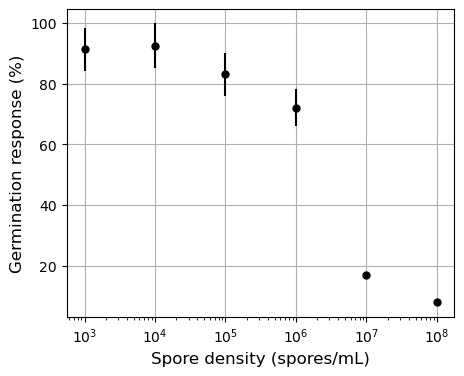

In [13]:
spore_densities = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
germination_responses_A = [91.3, 92.5, 83.0, 72.0, 17.0, 8.0]
confidence_intervals_A = [7.1, 7.4, 7.0, 6.1, 0.3, 0.3]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.errorbar(spore_densities, germination_responses_A, yerr=confidence_intervals_A, fmt="o", color="black", markersize=5, label="Germination response")
ax.set_xlabel("Spore density (spores/mL)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.set_xscale("log")
ax.grid()

gcf()

A sigmoidal tendency is observable in the data, hinting at a non-linear relationsip between the spore density and the rate of germination.

### 2.2. Measured relationship between added 1-octen-3-ol and germination success

The effect of added 1-octen-3-ol concentrations to a spore inoculum of density $10^5$ spores/mL, measured at 10 hours of incubation, is as follows:

|mM|1.0|2.5|4.0|5.0|
|----------|--------------|--------------|--------------|--------------|
|% Germination|$87\pm6.1$|$36\pm4.3$|$14\pm2.1$|$1\pm0.3$|

The control experiment yields a germination success of $95\pm5.3\%$.

Fitted parameters: 5.09074242509029 -0.01882370806130874


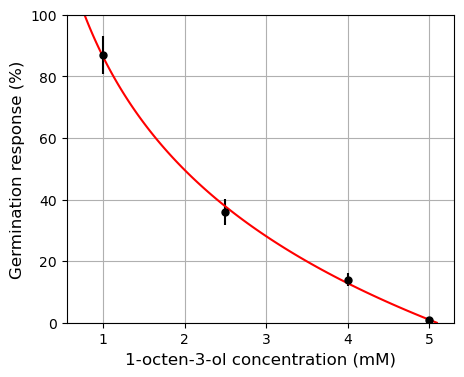

In [ ]:
concentrations = [1.0, 2.5, 4.0, 5.0]
germination_responses_B = [87, 36, 14, 1]
confidence_intervals_B = [6.1, 4.3, 2.1, 0.3]

# Fit exponential model to data
fit = exp_fit(germination_responses_B, concentrations)
println("Fitted parameters: ", fit[1], " ", fit[2])

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.errorbar(concentrations, germination_responses_B, yerr=confidence_intervals_B, fmt="o", color="black", markersize=5, label="Germination response")
sample_pts = LinRange(0, 100, 100)
ax.plot(fit[1] * exp.(fit[2] .* sample_pts), sample_pts, color="red", label="Fitted curve")
ax.set_xlabel("1-octen-3-ol concentration (mM)", fontsize=12)
ax.set_ylabel("Germination response (%)", fontsize=12)
ax.grid()
ax.set_ylim(0, 100)

gcf()

Interestingly, a logarithmic function yields the closest fit through the data.

### 2.3. Equating the results via the established model

Following our hypothesis and the inhibitor saturation model derived earlier, the concentration of inhibitor in the spore follows the formula

$$
\begin{equation}
c_{\textrm{in}}{(t)}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t}{\tau(1-\phi)}}\right].
\end{equation}
$$

where $\phi=\rho V_s$ is the volume fraction occupied by the spores.

<!-- Separating the $c_0$-dependent terms and rewriting the equation yields an expression for the initial concentration:

$$
\begin{equation}
c_{\textrm{in}}{(t)}=\phi c_0+(1-\phi)c_0e^{-\frac{t}{\tau(1-\phi)}} + (1-\phi)c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi)}}\right],
\end{equation}
$$

$$
\begin{equation}
c_{\textrm{in}}{(t)}-(1-\phi)c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi)}}\right]=c_0\left[\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}\right],
\end{equation}
$$

$$
\begin{equation}
c_0=\frac{c_{\textrm{in}}{(t)}-(1-\phi)c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi)}}\right]}{\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}}.
\end{equation}
$$

In the case of a zero added exogenous concentration, the above term reduces to

$$
\begin{equation}
c_0=\frac{c_{\textrm{in}}{(t)}}{\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}}.
\end{equation}
$$

**Correlating the empirical results** -->

Assuming that the two germination experiments contain spores with the same distribution of heterogeneity, an equivalent average concentration drop would lead to an equivalent germination percentage. It is easy to fit an exponential relationship through the data points for germination percentage and inhibitor concentration in the second model. Evaluating this function at the germination percentages from the first experiment, one can obtain the exogenous 1-octen-3-ol concentration equivalents of the different spore densities.

For simplicity, it is assumed that both results are valid for 10 hours of incubation, even though the first measurements were taken at the 11-hour mark. At a first glance, the germination rate of $95\pm5.3\%$ for control experiment at $10^5$ spores/mL and zero added inhibitor has a minor confidence interval overlap with the $83\pm7.0\%$ germination success of the $10^5$ spores/mL setup in the variable spore density experiments. Since further data on the samples is lacking, this can be taken as sufficient evidence that the results follow the same distribution.

In [15]:
ex_conc_equivalents = fit[1] * exp.(fit[2] .* germination_responses_A)

for i in 1:length(germination_responses_A)
    println("Spore density: ", spore_densities[i], " Germination response: ", germination_responses_A[i], " Exogenous concentration equivalent: ", ex_conc_equivalents[i])
end

Spore density: 1000.0 Germination response: 91.3 Exogenous concentration equivalent: 0.912852591491095
Spore density: 10000.0 Germination response: 92.5 Exogenous concentration equivalent: 0.8924638090818455
Spore density: 100000.0 Germination response: 83.0 Exogenous concentration equivalent: 1.0672186913225532
Spore density: 1.0e6 Germination response: 72.0 Exogenous concentration equivalent: 1.3127401879158425
Spore density: 1.0e7 Germination response: 17.0 Exogenous concentration equivalent: 3.6966264831416455
Spore density: 1.0e8 Germination response: 8.0 Exogenous concentration equivalent: 4.379059673750989


If one equates the internal concentration under density-driven saturation to the one under exogenously added inhibitor, the following equation is obtained:

$$
\begin{equation}
\phi c_0+(1-\phi)\left(c_0e^{-\frac{t}{\tau(1-\phi)}}\right)=\phi' c_0+(1-\phi')\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t}{\tau(1-\phi')}}\right],
\end{equation}
$$

where $\phi'$ is the volume fraction at the reference density of $\rho'=10^5$ spores/mL. The two unknown variables in this system are $\tau$ (in particular, its $P_s$ component) and $c_0$. Separating the $c_0$-dependent terms,

$$
\begin{equation}
c_0\left[\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}\right]=c_0\left[\phi' +(1-\phi')e^{-\frac{t}{\tau(1-\phi')}}\right] + (1-\phi')c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi')}}\right],
\end{equation}
$$

and rewriting for $c_0$,

$$
\begin{equation}
c_0\left[\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}-\phi' -(1-\phi')e^{-\frac{t}{\tau(1-\phi')}}\right]=(1-\phi')c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi')}}\right],
\end{equation}
$$

$$
\begin{equation}
c_0=\frac{(1-\phi')c_{\textrm{ex}}\left[1- e^{-\frac{t}{\tau(1-\phi')}}\right]}{\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}-\phi' -(1-\phi')e^{-\frac{t}{\tau(1-\phi')}}}.
\end{equation}
$$

The term in the denominator can assume negative values for densities smaller than the reference spore density. This makes sense, because according to the mathematical approach, $\rho_s'=10^5$ corresponds to the "ground-zero" from which additions in exogenous concentrations correspond to additions of spores. Conversely, if spores are taken away from the reference point, the corresponding exogenous concentration would be negative, i.e. inhibitor molecules need to be removed from the system.

One can examine whether, having the same $\tau$, this formula produces consistent results for $c_0$ under varying spore densities linked to exogenous concentrations from the 10-hour experimental measurements. To this end, a minimisation procedure is implemented, which fits a variable $P_s$ with respect to minimising the standard deviation of $c_0$ under the given $c_{\textrm{ex}}$ inputs. The standard deviation is thereby normalised by dividing by the mean $\langle c_0\rangle_{c_{\textrm{ex}}}$

[1000.0, 10000.0, 100000.0, 1.0e6, 1.0e7, 1.0e8]
[0.912852591491095, 0.8924638090818455, 1.0672186913225532, 1.3127401879158425, 3.6966264831416455, 4.379059673750989]
c₀: [-0.0002062836018415309, -0.000277434745875132, -0.0003416276193411824, -0.00042144490317281224, -0.0011871175873169105, -0.001406311879332602]
Minimum coefficient of variation 2.164725589359492 for P_s=1.0006910833004609e-13: <c_0>=2.6054106210868704e-6
[1.406620959049648e-5, 1.3752073625728871e-6, 1.644488012471892e-7, 2.0228002467326703e-8, 5.695725824261308e-9, 6.742439130738761e-10]


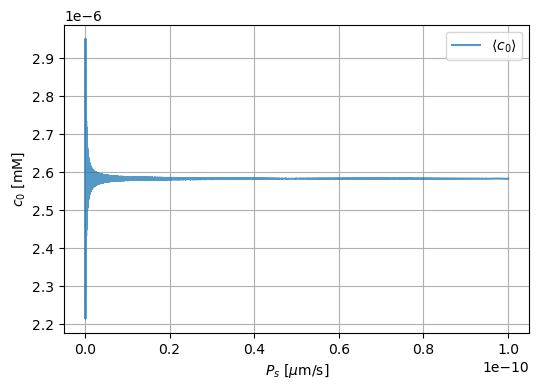

In [16]:
# Example usage:
spore_diameter = 5.0
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)       # Surface area and volume of the sphere
Ps_fit = 0.0002675353069511818                                          # Permeation constant
t = 36000                                                           # Total integration time (10 hours)

println(spore_densities)
println(ex_conc_equivalents)

function calc_c0(t, ρ_ref, Pₛ, A, V)
    ρ = spore_densities
    c_ex = ex_conc_equivalents
    ϕ = ρ .* V
    ϕ_ref = ρ_ref * V
    τ = V / (A * Pₛ) # Decay time constant
    c₀ = (1 - ϕ_ref) .* c_ex .* (1 - exp(-t/(τ * (1-ϕ_ref)))) ./ (ϕ .+ (1 .- ϕ) .* exp.(-t./(τ.-ϕ)) .- ϕ_ref .- (1 - ϕ_ref) * exp(-t/(τ * (1-ϕ_ref))))
    return c₀
end

c₀ = calc_c0(t, 1e5, Ps_fit, A, V)
println("c₀: ", c₀)

Ps_vals = 10 .^ LinRange(-13, -10, 10000)

c0_means = zeros(length(Ps_vals))
c0_norm_vars = zeros(length(Ps_vals))
for i in 1:length(Ps_vals)
    c0 = calc_c0(t, 1e5, Ps_vals[i], A, V)
    c0_means[i] = mean(c0)
    c0_norm_vars[i] = std(c0) / abs(c0_means[i])
end

min_idx = argmin(c0_norm_vars)
println("Minimum coefficient of variation ", c0_norm_vars[min_idx]," for P_s=$(Ps_vals[min_idx]): <c_0>=$(c0_means[min_idx])")
println(calc_c0(t, 1e5, Ps_vals[min_idx], A, V))

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(Ps_vals, c0_means[:], label=L"\langle c_0\rangle", alpha=0.75)
# ax.plot(Ps_vals, c0_norm_vars[:], label=L"\text{CV}{(c_0)}", alpha=0.75)
# ax.axvline(Ps_vals[min_idx], color="red", linestyle="--", label="Minimum variance")
ax.set_xlabel(L"P_s\ [\mu\text{m/s}]")
ax.set_ylabel(L"c_0\ [\text{mM}]")
ax.grid()
ax.legend()

gcf()

The resulting solutions for the mean initial concentration consistently fluctuate close to $\langle c_0\rangle\approx 2.58\times 10^{-6}\ \textrm{mM}=2.58\times 10^{-9}\ \textrm{M}$, a physically sensible value. This is accompanied by a constant coefficient of variability, indicating that the model does not perfectly succeed in explaining and linking the experimental data.

<!-- The problem could also be formulated in an inverse way - fix $c_0$ and vary $\rho$ to observe the changes in $c_{\textrm{ex}}$, expressed as


$$
\begin{equation}
c_{\textrm{ex}}=c_0\left[\frac{\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}-\phi' -(1-\phi')e^{-\frac{t}{\tau(1-\phi')}}}{(1-\phi')\left[1- e^{-\frac{t}{\tau(1-\phi')}}\right]}\right].
\end{equation}
$$ -->

### 2.4. Heuristics for finding $c_0$

Another approach that can be used to estimate the upper limit of the inhibitor concentration is by referring to the measured concentration of 1-octen-3-ol released by conidia. Studies with _A. flavus_ have shown that, even after repetitive freeze-dry treatment to destroy the integrity of the conidial envelope, the released concentration of 1-octen-3-ol in the medium was below $1\ \mu\textrm{M}$ [11]. The experiment was performed at a conidial density of $10^9$ spores/mL in a $300\ \mu\textrm{L}$ suspension, which is equivalent to $3\times 10^8$ spores. The quantity of 1-octen-3-ol in the volume of the suspension can be calculated to $3\times 10^{-10}$ moles. Distributing these molecules over the spherical volumes of the conidia, equal to $\frac{4}{3}\pi R^3=6.54\times 10^{-14}\ \textrm{L}$ each, results in a maximum concentration of $1.5\times 10^{-5}\ \textrm{M}$ per conidium.

As for the concentration of the second inhibitor candidate, the heat-labile peptide, a precise estimate is difficult to pinpoint, but a moderate abundance would likely be in the micromolar order, $c_0=\mathcal{O}{(10^{-6})}\ \textrm{M}$. This is only an order lower than the estimate for 1-octen-3-ol, so the concentration load of the VOC can also be used in this case, for simplicity.

### 2.5. Threshold for inhibition

The threshold for inhibition is another variable that can be narrowed down using experimental observations. Resorting to the _A. nidulans_ studies [10], it is evident that an exogenously added $1\ \textrm{mM}$ of 1-octen-3-ol already causes inhibition. In studies with _A. flavus_, not less than $10\ \textrm{mM}$ added 1-octen-3-ol was needed to induce inhibition [11]. Both of these values are much higher than the supposed initial concentration at the spore. This is logical, if one considers that a significant $c_{\textrm{out}}$ concentration is needed to delay the endogenous release of inhibitor from the spore.

Despite the flaws of the model in reconstructing a coherent initial concentration, an attempt can be made to use it for finding the concentration threshold $c_T$ given the empirical germination data. Given the heterogeneity of the spores and the fact that there is no hard threshold beyond which all of them stop germinating, the first question is how to define $c_T$ based on germination statistics.

![Inhibitor thresholds](Data/inhibitor_thresholds.png)

<!-- It can be assumed that each spore has a slightly varying release rate, leading to a concentration $c{(t_{\textrm{max}})}=C$ at the time of measurement $t_{\textrm{max}}$, where $C$ is a random variable. Concurrently, each spore has its inherent, sligthly varying concentration threshold for germination $T$, which is also a random variable, albeit not necessarily correlated with or from the same distribution as $C$.

Thus, a spore germinates if $C<T$. In the case when all spores germinate, it is guaranteed that the highest $C$ is lower than the lowest $T$. If the environmental conditions change in a way that the release is affected, it can be assumed that the distribution $C$ shifts upward in a consistent manner. Then, the germination fraction can be expressed as

$$
\begin{equation}
p=P(C<T).
\end{equation}
$$

In order to capture $C$ into a single final concentration variable $c_F$, we need to define $c_F$ such that, if all spores had the same effective final concentration, their germination fraction would be the same under the changed environmental conditions:

$$
\begin{equation}
p=P(c_F<T).
\end{equation}
$$

Let $F_T$ denote the cumulative distribution function of the thresholds (the probability that the threshold is less than or equal to a given value). Then,

$$
\begin{equation}
p=P(T>c_F)=1-F_T(c_F).
\end{equation}
$$

Solving for $c_F$, one obtains the expression

$$
\begin{equation}
c_F=F_T^{-1}(1-p).
\end{equation}
$$

For simplicity, one can assume that the shift in $c{(t_{\textrm{max}})}$ under changing the germination conditions is a constant for all spores, denoted as $\Delta$. Thus, the transformed final concentrations become

$$
\begin{equation}
c{(t_{\textrm{max}})}=C+\Delta.
\end{equation}
$$

Consequently, the effective final concentrations also change by the same amount:

$$
\begin{equation}
c_F^{\textrm{shifted}}=c_F+\Delta.
\end{equation}
$$

Rearranging this, one can express the shift as

$$
\begin{equation}
\Delta=c_F^{\textrm{shifted}}-c_F=F_T^{-1}(1-p_2)-F_T^{-1}(1-p_1),
\end{equation}
$$

where $p_1$ is the fraction of germinated spores before the shift and $p_2$ is the updated fraction of germinated spores.

Starting with the simpler analytical scheme,

$$
\begin{equation}
c_T=\left(I_{\textrm{self}} + \rho_s I_{\textrm{bg}} - 1\right)\Delta{c}{(0)}e^{-\frac{t}{\tau}}
\end{equation}
$$ -->

The general formula for the concentration at the measurement time $t_\textrm{max}$ can be expressed as:

$$
\begin{equation}
c_{\textrm{in}}{(t_\textrm{max})}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t_\textrm{max}}{\tau(1-\phi)}}\right].
\end{equation}
$$

The characteristic relaxation time depends on the surface-to-volume ratio of the spore and may exhibit variability within the inoclulum, therefore it is modelled by a random variable. Thus, denoting the final measured concentration as $c_F$,

$$
\begin{equation}
c_F{(\tau, c_{\textrm{ex}})}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t_\textrm{max}}{\tau(1-\phi)}}\right].
\end{equation}
$$

The condition for germination is that the final concentration is below the germination threshold $c_T$, which is also a random variable:

$$
\begin{equation}
c_F{(\tau, c_{\textrm{ex}})}\le c_T.
\end{equation}
$$

Conditional on $\tau$, the probability that a spore germinates is

$$
\begin{equation}
P(\textrm{germination}\ | \ \tau)=P(c_T\ge c_F{(\tau, c_{\textrm{ex}})})=1-P(c_F{(\tau, c_{\textrm{ex}})}>c_T)=1-F_\Theta(c_F{(\tau, c_{\textrm{ex}})}),
\end{equation}
$$

where $F_\Theta(x)$ is the cumulative distribution function (CDF) of the germination thresholds. Averaging over the distribution of $\tau$, one can find the fraction $G$ of spores that germinate under a given $c_{\textrm{ex}}$:

$$
\begin{equation}
G(c_{\textrm{ex}})=\int{p{(\tau)}\left[1-F_\Theta\left(c_F{(\tau, c_{\textrm{ex}})}\right)\right]d{\tau}},
\end{equation}
$$

where $p{(\tau)}$ is the probability density of $\tau$. For the sake of simplicity, it can be assumed that the characteristic $\tau$ does not vary significantly, compared to the germination thresholds - it mostly depends on the spherical area-to-volume ratio, which only sligthly changes among spores, while the threshold may be related to more complex physiological characteristics. In this case, the above fraction can be approximated using an average $\bar{\tau}$:

$$
\begin{equation}
G(c_{\textrm{ex}})\approx 1-F_\Theta\left(c_F{(\bar{\tau}, c_{\textrm{ex}})}\right).
\end{equation}
$$

Assuming that the distribution of threshold concentrations is symetric, its mean would coincide with its median. Thus, one can identify a reference point in the exogenous concentration addition when the germination response is 50%:

$$
\begin{equation}
G(c_{\textrm{ex}}^{50\%})=0.5,
\end{equation}
$$

and substitute the germination fraction in the general formula:

$$
\begin{equation}
0.5= 1-F_\Theta\left(\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t_\textrm{max}}{\bar{\tau}(1-\phi)}}\right]\right),
\end{equation}
$$

$$
\begin{equation}
F_\Theta\left(\phi c_0+(1-\phi)\left[c_{\textrm{ex}}+\left(c_0-c_{\textrm{ex}}\right)e^{-\frac{t_\textrm{max}}{\bar{\tau}(1-\phi)}}\right]\right)=0.5.
\end{equation}
$$

This means that the mean of the thresholds can be expressed as

$$
\bar{c_T}=\phi c_0+(1-\phi)\left[c_{\textrm{ex}}^{50\%}+\left(c_0-c_{\textrm{ex}}^{50\%}\right)e^{-\frac{t_\textrm{max}}{\bar{\tau}(1-\phi)}}\right].
$$

Using this formula, the threshold for 1-octen-3-ol inhibition is computed below for all candidate permeabilities at time $t_{\textrm{max}}=10\ \textrm{h}$.

In [17]:
c0 = 1.5 # 1e-5 M
t_max = 36000 # 10 hours
A, V = compute_spore_area_and_volume_from_dia(5.0)
Ps_variants = [2e-10, 0.1725, 0.0039] # [cm/s]
Ps_variants = [cm_to_um(Ps) for Ps in Ps_variants]

D = 600
B = 1.0

c_ex_median = fit[1] * exp.(fit[2] .* 50)
println("c_ex_median: ", c_ex_median)

for Ps in Ps_variants

    # Constants
    τ = V / (A * Ps) # Decay time constant
    ϕ = inverse_mL_to_cubic_um(1e5) * V # Volume fraction of spores in the solution
    
    c_thresh = ϕ * c0 + (1 - ϕ) * (c_ex_median + (c0 - c_ex_median) * exp(-t_max / (τ * (1 - ϕ)))) # Threshold concentration
    println("P_s: ", Ps, " c_thresh: ", c_thresh)
end

c_ex_median: 1.9862298149123427
P_s: 2.0e-6 c_thresh: 1.5402465594669668
P_s: 1724.9999999999998 c_thresh: 1.986226632545646
P_s: 39.0 c_thresh: 1.986226632545646


The issue arising from the results is that all computed thresholds are higher than the initial concentration. This could be traced back to the fact that the median of the exogenous concentration itself is higher than the concentration in the spores, meaning that the concentration jump is reversed immediately at the beginning of the process, effectively leading to a sole intake of external inhibitor into the spore. This is not consistent with a realistic scenario, therefore the method is not appropriate for inferring meaningful threshold levels.

A simple assumption for the lower bound of the inhibition threshold $c_T$ would be that the inhibitor stops working once there are only about a hundred molecules left in the spore. Referring this amount to the volume of a spore with a diameter of $5\ \mu\textrm{m}$, one arrives at a concentration of approximately $2.54\times 10^{-9}\ \textrm{M}$.

## 3. Comparing the different inhibitor release scenarios

Using the diffusion coefficient assumptions, the time-dependent inhibitor release is computed once for the separate barrier components in isolation and once for the different barrier compositions, using the simple permeation scheme. Parallel to that, different thresholds of inhibition at $t=4\ \textrm{h}$, from $10^{-5}$ to $10^{-10}\ \textrm{M}$, are tested to find the corresponding permeation constants leading to their attainment. Furthermore, considering a possible delay between the threshold attainment and the swelling onset, an earlier time for reaching the thresholds, $t=2\ \textrm{h}$, is also tested to see how the permeabilities change.

P_s: 0.00015671586811934085 c_T: 0.1 (4 h)
P_s: 0.00028996732026019995 c_T: 0.010000000000000002 (4 h)
P_s: 0.0004232187724010591 c_T: 0.001 (4 h)
P_s: 0.0005564702245419183 c_T: 0.0001 (4 h)
P_s: 0.0006897216766827773 c_T: 1.0e-5 (4 h)
P_s: 0.0003134317362386817 c_T: 0.1 (2 h)
P_s: 0.0005799346405203999 c_T: 0.010000000000000002 (2 h)
P_s: 0.0008464375448021181 c_T: 0.001 (2 h)
P_s: 0.0011129404490838365 c_T: 0.0001 (2 h)
P_s: 0.0013794433533655546 c_T: 1.0e-5 (2 h)


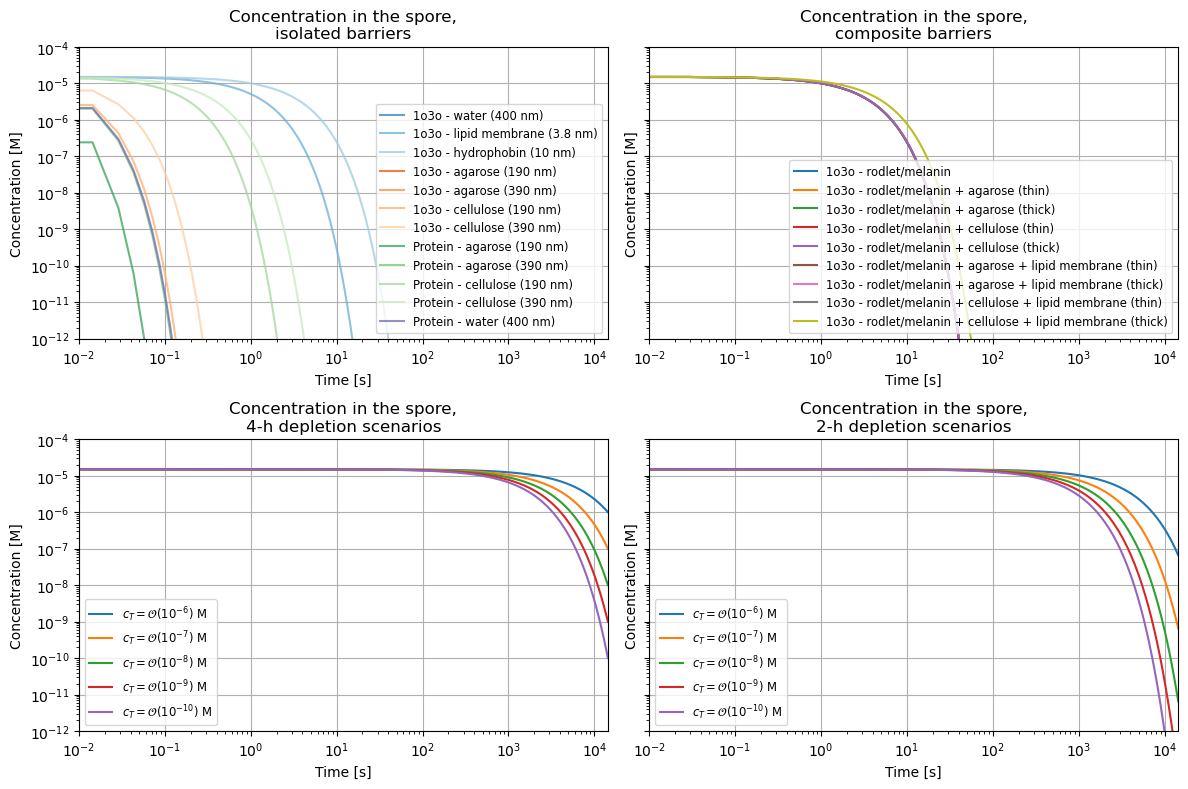

In [14]:
spore_diameter = 5.0 # um
A, V = compute_spore_area_and_volume_from_dia(spore_diameter)
c₀ = 1.5 # 1e-5 M

t_max = 14400 # 4 hours
n_frames = 1000000
times = collect(LinRange(0, t_max, n_frames))

# ----- 1-octen-3-ol in isolated layers -----
D = cm2_to_um2(6.906e-6) # [um^2/s]
# Ps_variants = [2e-10, 0.1725, 0.0039] # [cm/s]
# Ps_variants = [0.17254, 0.17696, 0.0050141, 9.04e-5, 3.43e-5] # [cm/s]
Ps_variants = [0.17254, 9.04e-5, 3.43e-5] # [cm/s]
Ps_variants = cm_to_um.(Ps_variants)
# labels_oct = ["1o3o - water (400 nm)", "1o3o - agarose (390 nm)", "1o3o - cellulose (390 nm)", "1o3o - lipid membrane (3.8 nm)", "1o3o - hydrophobin (10 nm)"]
labels_oct_general = ["1o3o - water (400 nm)", "1o3o - lipid membrane (3.8 nm)", "1o3o - hydrophobin (10 nm)"]

c_vals_oct_general = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_oct_general, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
end

Ps_variants = [0.36324, 0.17696, 0.010292, 0.0050141] # [cm/s]
Ps_variants = cm_to_um.(Ps_variants)
labels_oct_polys = ["1o3o - agarose (190 nm)", "1o3o - agarose (390 nm)", "1o3o - cellulose (190 nm)", "1o3o - cellulose (390 nm)"]

c_vals_oct_polys = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_oct_polys, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
end

# ----- 1-octen-3-ol in composite wall -----
Ps_variants = [3.43e-5, 3.43e-5, 3.429e-5, 3.419e-5, 3.407e-5, 2.486-5, 2.486-5, 2.481-5, 2.474e-5] # [cm/s]
Ps_variants = cm_to_um.(Ps_variants)
labels_oct_comp = ["1o3o - rodlet/melanin", "1o3o - rodlet/melanin + agarose (thin)", "1o3o - rodlet/melanin + agarose (thick)",
                    "1o3o - rodlet/melanin + cellulose (thin)", "1o3o - rodlet/melanin + cellulose (thick)",
                    "1o3o - rodlet/melanin + agarose + lipid membrane (thin)", "1o3o - rodlet/melanin + agarose + lipid membrane (thick)",
                    "1o3o - rodlet/melanin + cellulose + lipid membrane (thin)", "1o3o - rodlet/melanin + cellulose + lipid membrane (thick)"]

c_vals_oct_comp = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_oct_comp, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
end

# ----- Heat-labile peptide in isolated layers -----
D = cm2_to_um2(4.54855e-7) # [um^2/s]
# Ps_variants = [0.01137, 2.55e-4] # [cm/s]
Ps_variants = [0.0239397, 0.0116629, 6.789e-4, 3.3e-4, 0.01137]
Ps_variants = cm_to_um.(Ps_variants)
labels_prot = ["Protein - agarose (190 nm)", "Protein - agarose (390 nm)", "Protein - cellulose (190 nm)", "Protein - cellulose (390 nm)", "Protein - water (400 nm)"]

c_vals_prot = []
for (i, Ps) in enumerate(Ps_variants)
    push!(c_vals_prot, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
end

# Fit permeation constants for 4-hour inhibition
exponents = LinRange(-1, -5, 5)
cT_range = 10 .^ exponents
labels_fit = [L"c_T = \mathcal{O}{(10^{%$(round(Int, e - 5))}})\ \text{M}" for e in exponents]
Ps_fits_4h = compute_permeation_constant.(cT_range, 0.0, c₀, t_max, A, V)

# Simulate fitted Ps
c_vals_fit_4h = []
times_fit = []
for (i, Ps) in enumerate(Ps_fits_4h)
    push!(c_vals_fit_4h, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
    push!(times_fit, times)
    println("P_s: ", Ps, " c_T: ", cT_range[i], " (4 h)")
end

# Fit permeation constants for 2-hour inhibition
labels_fit = [L"c_T = \mathcal{O}{(10^{%$(round(Int, e - 5))}})\ \text{M}" for e in exponents]
Ps_fits_2h = compute_permeation_constant.(cT_range, 0.0, c₀, t_max * 0.5, A, V)

# Simulate fitted Ps
c_vals_fit_2h = []
for (i, Ps) in enumerate(Ps_fits_2h)
    push!(c_vals_fit_2h, permeation_time_dependent_analytical(c₀, 0, times, Ps, A, V) .* 1e-5)
    println("P_s: ", Ps, " c_T: ", cT_range[i], " (2 h)")
end

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=true)
compare_concentration_evolution_groups([c_vals_oct_general, c_vals_oct_polys, c_vals_prot],
                                        [[times for _ in 1:length(c_vals_oct_general)], [times for _ in 1:length(c_vals_oct_polys)], [times for _ in 1:length(c_vals_prot)]],
                                        [labels_oct_general, labels_oct_polys, labels_prot], ax[1, 1], logx=true, logy=true, title="Concentration in the spore,\nisolated barriers", ylim=(1e-12, 1e-4), legend_loc="lower right")
compare_concentration_evolutions(c_vals_oct_comp, [times for _ in 1:length(c_vals_oct_comp)], labels_oct_comp, ax[1, 2], logx=true, logy=true, title="Concentration in the spore,\ncomposite barriers", ylim=(1e-12, 1e-4), legend_loc="lower right")
compare_concentration_evolutions(c_vals_fit_4h, times_fit, labels_fit, ax[2, 1], logx=true, logy=true, title="Concentration in the spore,\n4-h depletion scenarios", ylim=(1e-12, 1e-4))
compare_concentration_evolutions(c_vals_fit_2h, times_fit, labels_fit, ax[2, 2], logx=true, logy=true, title="Concentration in the spore,\n2-h depletion scenarios", ylim=(1e-12, 1e-4))

ax[1, 1].legend(loc="lower right", fontsize="small")
ax[1, 2].legend(loc="lower right", fontsize="small")
ax[2, 1].legend(loc="lower left", fontsize="small")
ax[2, 2].legend(loc="lower left", fontsize="small")

fig.tight_layout()

gcf()

The results confirm that, under the assumed initial concentration, the permeation of 1-octen-3-ol and of the hypothetical protein through any of the barrier candidates, isolated or composite, occurs too fast to meet any realistic threshold at a time mark longer than 60 seconds.

The permeation constants needed for the attainment of the different thresholds are listed in the table below:

|$c_T$|$c_0\times 10^{-1}$|$c_0\times 10^{-2}$|$c_0\times 10^{-3}$|$c_0\times 10^{-4}$|$c_0\times 10^{-5}$|
|-|-------------------|-------------------|-------------------|-------------------|-------------------|
|$P_s(4\ \textrm{h})\ [\mu\textrm{m/s}]$|$0.000156715868$     |$0.00028996732$      |$0.000423218772$     |$0.000556470225$     |$0.000689721677$     |
|$P_s(1\ \textrm{h})\ [\mu\textrm{m/s}]$|$0.000313431736$     |$0.00057993464$      |$0.000846437545$     |$0.001112940449$     |$0.001379443353$     |

## References

- [1] Höber, R. Physikalische Chemie der Zelle und der Gewebe. Nature, 112, 93-93.
- [2] Zhang, T., & Fang, H. (2005). Effective Diffusion Coefficients of Glucose in Artificial Biofilms. Environmental Technology, 26, 155 - 160.
- [3] Carter, N., Towne, J., & Neivandt, D.J. (2021). Finite element analysis of glucose diffusivity in cellulose nanofibril peripheral nerve conduits. Cellulose, 28, 2791 - 2803.
- [4] Brul, S., Nussbaum, J., & Dielbandhoesing, S.K. (1997). Fluorescent probes for wall porosity and membrane integrity in filamentous fungi. Journal of Microbiological Methods, 28, 169-178.
- [5] Bresseleers, G.J., Goderis, H.L., & Tobback, P. (1984). Measurement of the glucose permeation rate across phospholipid bilayers using small unilamellar vesicles. Effect of membrane composition and temperature. Biochimica et biophysica acta, 772 3, 374-82 .
- [6] Jakubowski, H.V., Flatt, P., Agnew, H., & Larsen, D. (2022). Fundamentals of Biochemistry, a free and new LibreText book for Undergraduate Courses. The FASEB Journal, 36.
- [7] Yarrow, F., & Kuipers, B.W. (2011). AFM study of the thermotropic behaviour of supported DPPC bilayers with and without the model peptide WALP23. Chemistry and physics of lipids, 164 1, 9-15.
- [8] Mazzobre, M.F., Román, M., Mourelle, A.F., & Corti, H.R. (2005). Octanol-water partition coefficient of glucose, sucrose, and trehalose. Carbohydrate research, 340 6, 1207-11.
- [9] Beauvais, A., Bozza, S., Kniemeyer, O., Formosa, C., Balloy, V., Henry, C., Roberson, R.W., Dague, E., Chignard, M., Brakhage, A.A., Romani, L., & Latgé, J.P. (2013). Deletion of the α-(1,3)-Glucan Synthase Genes Induces a Restructuring of the Conidial Cell Wall Responsible for the Avirulence of Aspergillus fumigatus. PLoS Pathogens, 9.
- [10] Herrero-García, E., Garzia, A., Cordobés, S., Espeso, E.A., & Ugalde, U. (2011). 8-Carbon oxylipins inhibit germination and growth, and stimulate aerial conidiation in Aspergillus nidulans. Fungal biology, 115 4-5, 393-400.
- [11] Miyamoto, K., Murakami, T., Kakumyan, P., Keller, N.P., & Matsui, K. (2014). Formation of 1-octen-3-ol from Aspergillus flavus conidia is accelerated after disruption of cells independently of Ppo oxygenases, and is not a main cause of inhibition of germination. PeerJ, 2.
- [12] Wang, X., Shi, F., Wösten, H.A., Hektor, H.J., Poolman, B., & Robillard, G.T. (2005). The SC3 hydrophobin self-assembles into a membrane with distinct mass transfer properties. Biophysical journal, 88 5, 3434-43 .
- [14] Brodin, B., Steffansen, B., & Nielsen, C.U. (2010). Passive diffusion of drug substances: the concepts of flux and permeability.
- [15] Gobas, F.A., Lahittete, J.M., Garofalo, G., Shiu, W.Y., & Mackay, D. (1988). A novel method for measuring membrane-water partition coefficients of hydrophobic organic chemicals: comparison with 1-octanol-water partitioning. Journal of pharmaceutical sciences, 77 3, 265-72 .